In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import jsonlines
import torchaudio
from torchaudio import transforms
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import Dataset
import torch
import librosa
import jiwer
import json
import re
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import numpy as np

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0))

CUDA available: True
Number of GPUs: 1
GPU Name: Tesla T4


In [4]:
cur_dir = os.getcwd()
src_dir = os.path.dirname(cur_dir)
til_dir = os.path.dirname(os.path.dirname(src_dir))
home_dir = os.path.dirname(til_dir)
test_dir = os.path.join(home_dir, 'novice')
audio_dir = os.path.join(test_dir, 'audio')
data_dir = os.path.join(cur_dir, 'data')
# model_path = os.path.join(src_dir, "models", "whisper")
csv_file_path = os.path.join(cur_dir, 'data', 'audio_lengths.csv')
config_path = os.path.join(cur_dir, "config.yaml")

# paths for converting datasets to manifest files
train_path = os.path.join(data_dir, 'train_data')
val_path = os.path.join(data_dir, 'val_data')
test_path = os.path.join(data_dir, 'test_data')

BATCH_SIZE = 200

In [14]:
def get_audio_length(audio_path, audio_dir, processor):
    try:
        waveform, sample_rate = torchaudio.load(os.path.join(audio_dir, audio_path))
        waveform = waveform.numpy().flatten()

        # Resample if needed
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(torch.tensor(waveform)).numpy().flatten()

        # Extract audio features
        audio_features = processor.feature_extractor(waveform, sampling_rate=16000).input_features[0]
        return int(len(audio_features))  # Ensure the length is a Python int
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

audio_lengths = [(audio, get_audio_length(audio, audio_dir, processor)) for audio in data['audio']]
audio_lengths = [length for length in audio_lengths if length[1] is not None]  # Remove None values

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['audio_file', 'length'])
    writer.writerows(audio_lengths)

print(f"Saved audio lengths to {csv_file_path}")

Saved audio lengths to /home/jupyter/til-24-base/asr/src/whisper_2/data/audio_lengths.csv


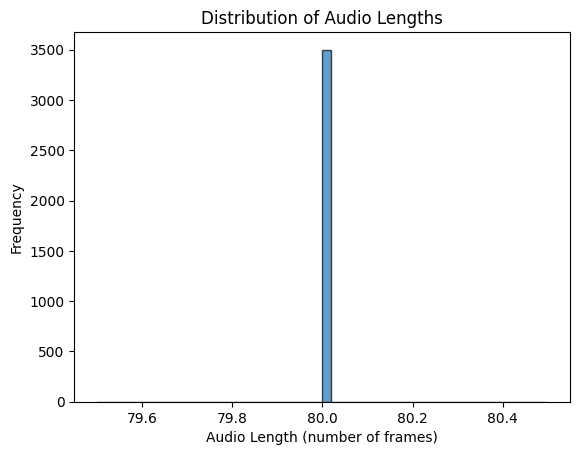

Max length: 80
Mean length: 80.0
50th percentile: 80.0
75th percentile: 80.0
90th percentile: 80.0
95th percentile: 80.0
99th percentile: 80.0


In [15]:
import csv
import matplotlib.pyplot as plt
import numpy as np

# Read the audio lengths from CSV
audio_files = []
audio_lengths = []

with open(csv_file_path, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        audio_files.append(row[0])
        audio_lengths.append(int(row[1]))

# Plot the distribution of audio lengths
plt.hist(audio_lengths, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Audio Length (number of frames)')
plt.ylabel('Frequency')
plt.title('Distribution of Audio Lengths')
plt.show()

# Print statistics
audio_lengths = np.array(audio_lengths)
print(f"Max length: {np.max(audio_lengths)}")
print(f"Mean length: {np.mean(audio_lengths)}")
# print(f"50th percentile: {np.percentile(audio_lengths, 50)}")
# print(f"75th percentile: {np.percentile(audio_lengths, 75)}")
# print(f"90th percentile: {np.percentile(audio_lengths, 90)}")
# print(f"95th percentile: {np.percentile(audio_lengths, 95)}")
# print(f"99th percentile: {np.percentile(audio_lengths, 99)}")

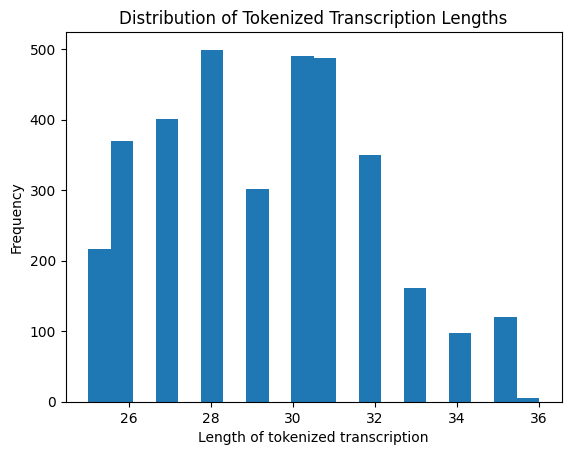

Maximum transcription length: 36


In [16]:
def get_transcription_length(transcript, processor, max_length=None):
    try:
        labels = processor.tokenizer(transcript, max_length=max_length, truncation=True).input_ids
        return len(labels)
    except Exception as e:
        print(f"Error processing transcription: {e}")
        return None
    
transcription_lengths = [get_transcription_length(transcript, processor) for transcript in data['transcript']]
transcription_lengths = [length for length in transcription_lengths if length is not None]  # Remove None values

# Analyze the lengths
plt.hist(transcription_lengths, bins=20)
plt.xlabel('Length of tokenized transcription')
plt.ylabel('Frequency')
plt.title('Distribution of Tokenized Transcription Lengths')
plt.show()

max_length = max(transcription_lengths)
print(f"Maximum transcription length: {max_length}")

In [17]:
def preprocess_audio(audio_path, transcript, processor, audio_dir, max_length=40):
    try:
        waveform, sample_rate = torchaudio.load(os.path.join(audio_dir, audio_path))
        waveform = waveform.numpy().flatten()

        # Resample if needed
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(torch.tensor(waveform)).numpy().flatten()

        # Extract audio features
        audio_features = processor.feature_extractor(waveform, sampling_rate=16000).input_features[0]

        # Compute input length of audio sample in seconds
        input_length = len(waveform) / 16000

        # Encode transcription text to label IDs
        labels = processor.tokenizer(transcript, max_length=max_length, truncation=True).input_ids

        return {
            'audio': {'array': waveform.tolist(), 'sampling_rate': 16000},
            'transcript': transcript,
            'input_features': audio_features.tolist(), 
            'input_length': input_length,
            'labels': labels
        }
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

def process_and_save_batches(data, processor, batch_size, audio_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i in range(0, len(data['audio']), batch_size):
        batch_data = {'audio': data['audio'][i:i+batch_size], 'transcript': data['transcript'][i:i+batch_size]}
        processed_batch = [preprocess_audio(audio, transcript, processor, audio_dir) for audio, transcript in zip(batch_data['audio'], batch_data['transcript'])]

        # Remove any None values due to errors
        processed_batch = [example for example in processed_batch if example is not None]

        # Save each batch to disk
        batch_output_path = os.path.join(output_dir, f'batch_{i//batch_size}.jsonl')
        with jsonlines.open(batch_output_path, mode='w') as writer:
            writer.write_all(processed_batch)

In [4]:
# from transformers import WhisperTokenizer, WhisperForConditionalGeneration, WhisperProcessor

# # Load the model and tokenizer
# model_name = 'openai/whisper-small'
# processor = WhisperProcessor.from_pretrained(model_name, language='English', task="transcribe")
# max_length = processor.tokenizer.model_max_length

# # Check the maximum length
# print(f"Maximum length for tokenizer: {max_length}")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Maximum length for tokenizer: 1024


In [18]:
total_size = None # number of files to process

data = {'key': [], 'audio': [], 'transcript': []}
data_path = os.path.join(test_dir, "asr.jsonl")
with jsonlines.open(data_path) as reader:
    for obj in reader:
        if total_size and len(data['key']) >= total_size:
            break
        for key, value in obj.items():
            data[key].append(value)

In [ ]:
# process_and_save_batches(data, processor, batch_size, audio_dir, data_dir)

In [9]:
# STILL CRASHES

# def load_batches_and_combine(output_dir):
#     combined_data = {'audio': [], 'transcript': [], 'input_features': [], 'input_length': [], 'labels': []}
    
#     for batch_file in os.listdir(output_dir):
#         if batch_file.endswith(".jsonl"):
#             batch_file_path = os.path.join(output_dir, batch_file)
#             with jsonlines.open(batch_file_path) as reader:
#                 for obj in reader:
#                     combined_data['audio'].append(obj['audio'])
#                     combined_data['transcript'].append(obj['transcript'])
#                     combined_data['input_features'].append(obj['input_features'])
#                     combined_data['input_length'].append(obj['input_length'])
#                     combined_data['labels'].append(obj['labels'])
    
#     return combined_data

# # Load and combine batches
# combined_data = load_batches_and_combine(data_dir)

# # Convert to Hugging Face dataset
# dataset = Dataset.from_dict(combined_data)

# # Cast the "audio" column to Audio type with the correct sampling rate
# dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

# # Shuffle the dataset
# dataset = dataset.shuffle(seed=42)

# # Split the dataset into training, validation, and test sets
# train_size = int(0.8 * len(dataset))
# val_size = int(0.1 * len(dataset))
# test_size = len(dataset) - train_size - val_size

# train_dataset = dataset.select(range(train_size))
# val_dataset = dataset.select(range(train_size, train_size + val_size))
# test_dataset = dataset.select(range(train_size + val_size, len(dataset)))

KeyboardInterrupt: 